In [12]:
import os
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from scipy.stats import linregress
from mne.time_frequency import psd_array_multitaper

from settings import paths
from helper_functions import save_figure

Since we're working with EMG, not EEG, frequency bands do not mean the same thing. Because of that, we will work with 10 equally split bands (10 freq point each)

In [19]:
freq_bands = {
    'PSD_band1': (0, 10), 'PSD_band2': (10, 20),
    'PSD_band3': (20, 30), 'PSD_band4': (30, 40),
    'PSD_band5': (40, 50), 'PSD_band6': (50, 60),
    'PSD_band7': (60, 70), 'PSD_band8': (70, 80),
    'PSD_band9': (80, 90), 'PSD_band10': (90, 100)
}

Let's load the epochs of one subject for testing purposes and drop the channels we are not interested in.

In [14]:
epochs_dir = os.path.join(paths["epochs_folder"], "ploss_thresh_500")

epochs = mne.read_epochs(os.path.join(epochs_dir, "filtered_epochs_w_movement_39508-epo.fif"), preload=True)

# let us drop the channels we are not interested in
epochs.drop_channels(['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3208
Events,1: 3208
Time range,0.000 – 4.999 s
Baseline,off


Define a dictionary with manually annotations of the 'good quality' EMG channels per subject.

In [20]:
quality_emgs = {
    81217: ["EMG_L"], 81175: ["EMG_L", "EMG_R"], 79592: ["EMG_R"], 79593: ["EMG_L"],
    81207: ["EMG_R"], 80625: ["EMG_R"], 80630: ["EMG_L", "EMG_R"], 78211: ["EMG_R"],
    39489: ["EMG_L"], 80620: ["EMG_L", "EMG_R"], 78227: ["EMG_L", "EMG_R"], 78233: ["EMG_R"],
    39508: ["EMG_L", "EMG_R"], 79604: ["EMG_L", "EMG_R"], 81218: ["EMG_L", "EMG_R"], 
    79602: ["EMG_L"], 78244: ["EMG_L", "EMG_R"],  81193: ["EMG_L", "EMG_R"],
}

## Epoch cleaning

In order to perform PCA and clustering, the data needs to be as clean as possible, which means we need to clean our epochs.

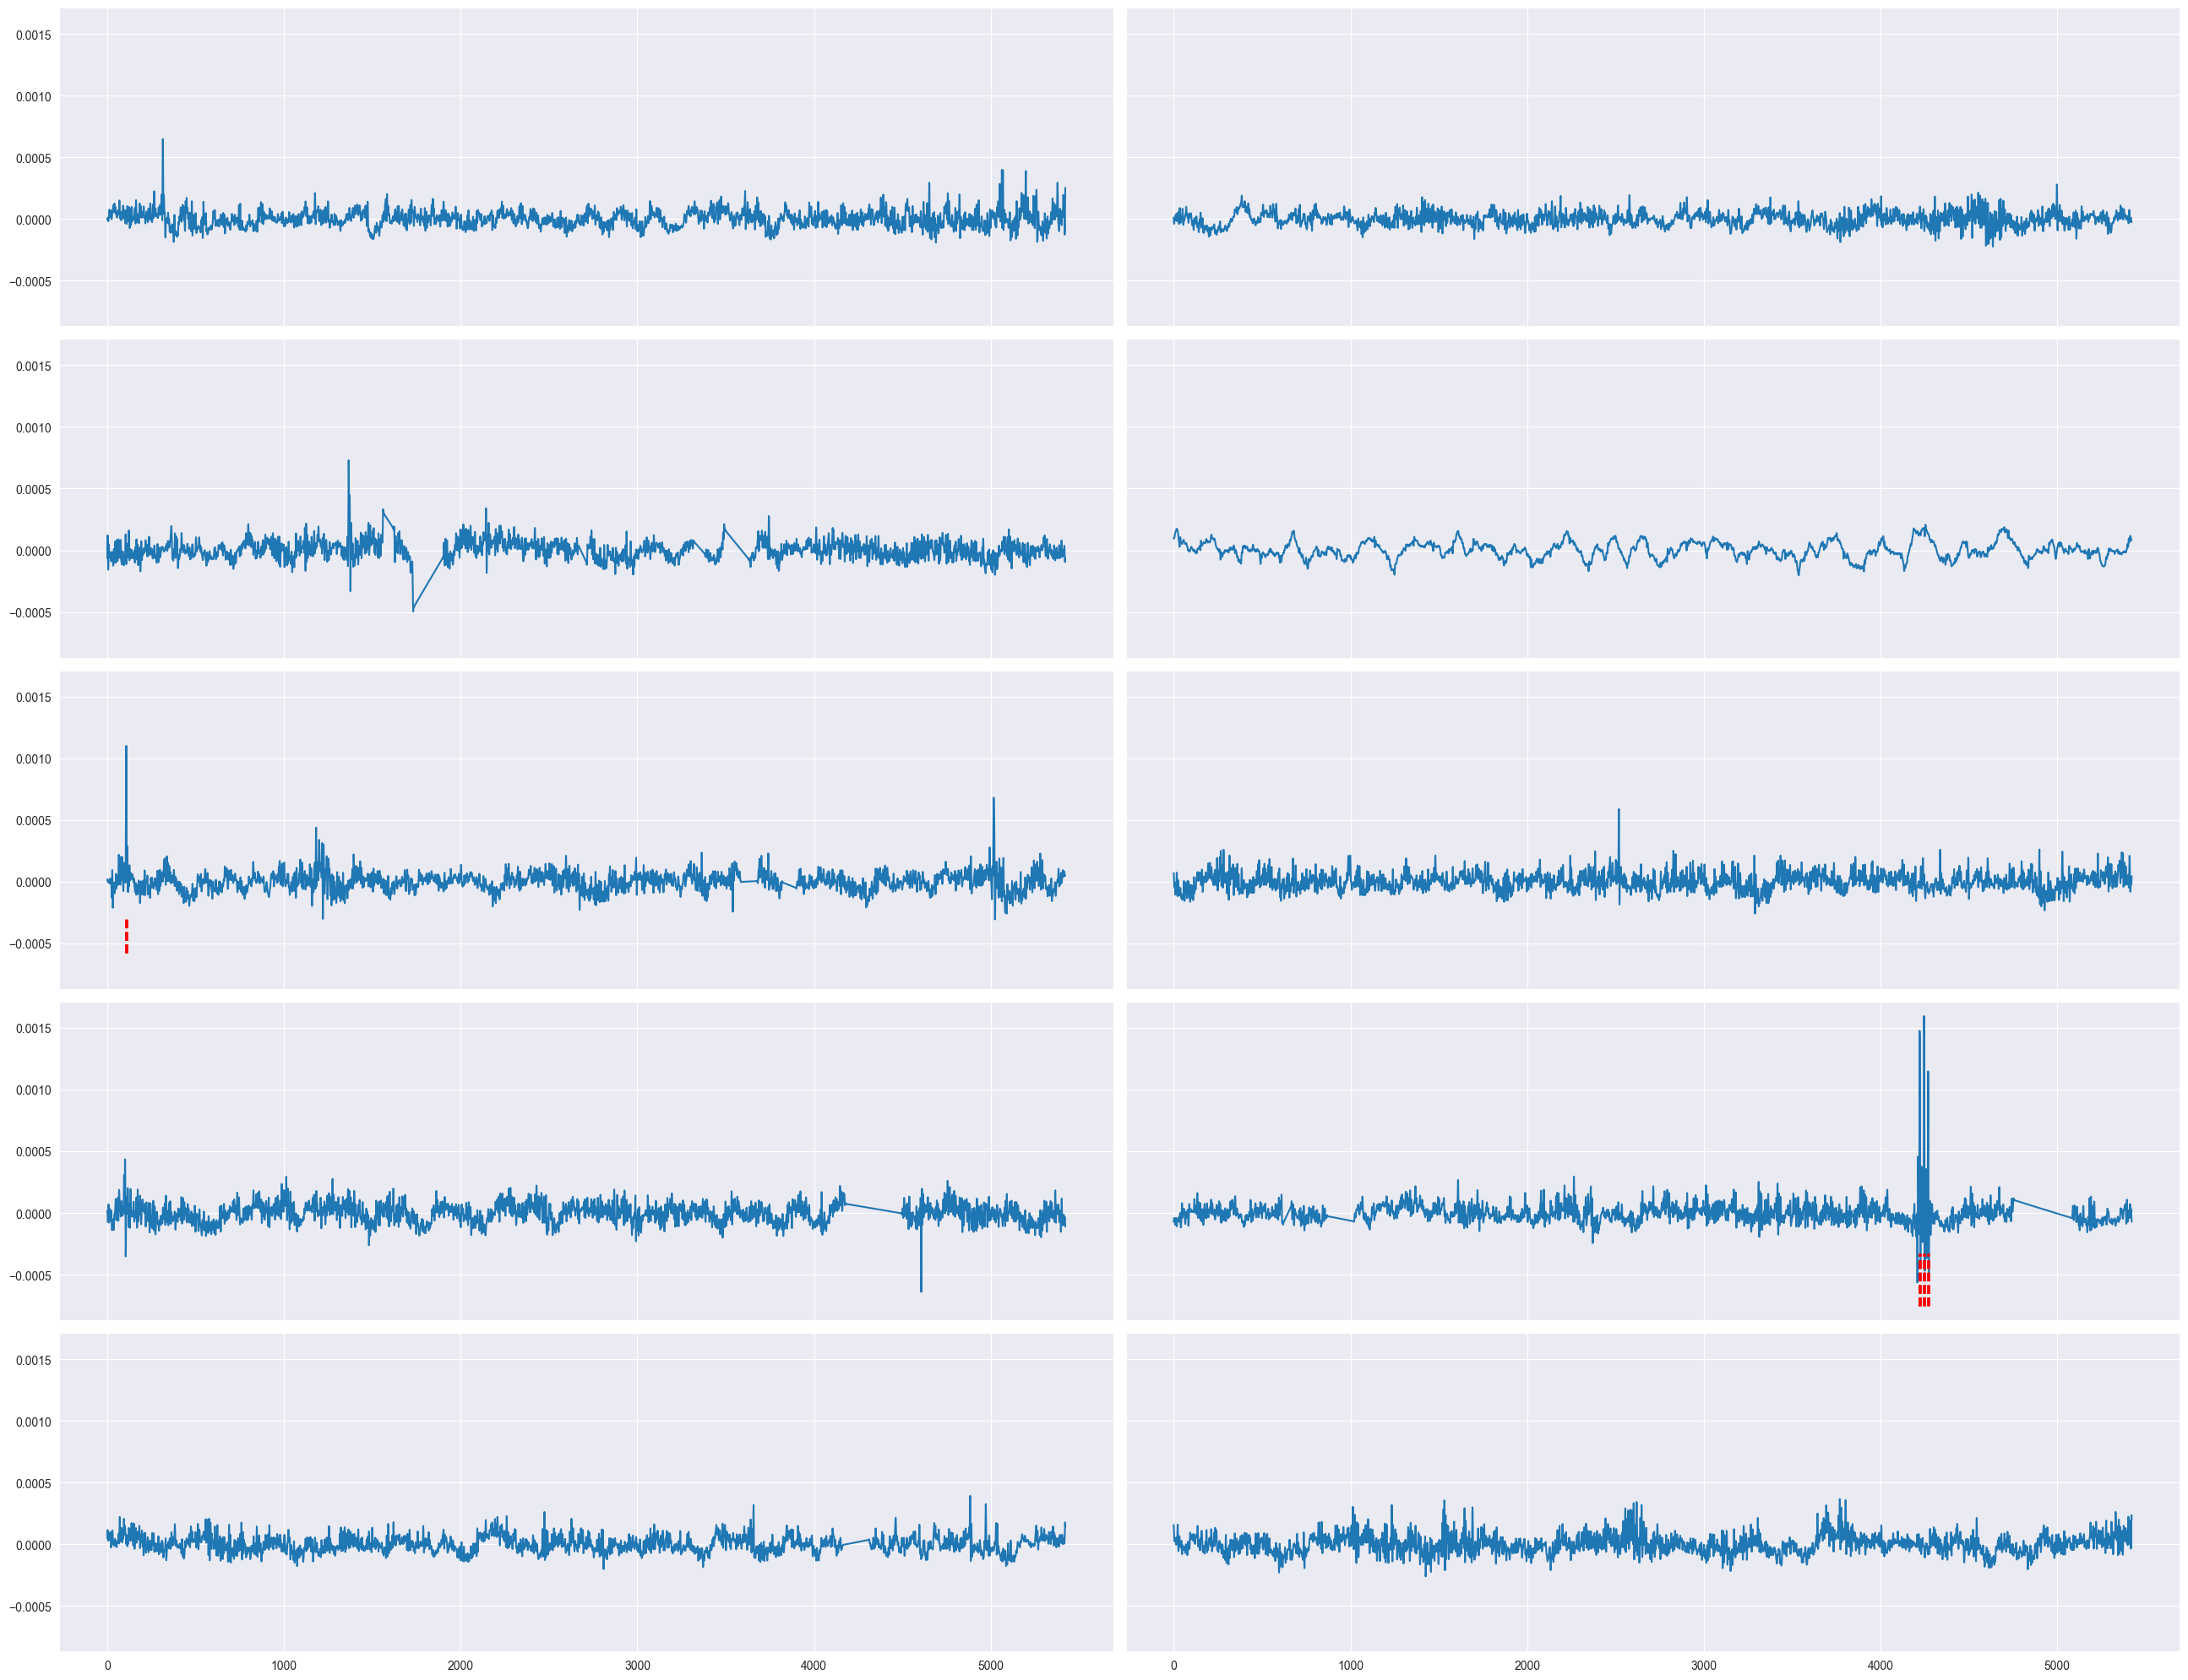

In [18]:
random_epoch_indexes = random.sample(range(0, len(epochs)), 10)
# random_epoch_indexes = [1036, 2046, 3152, 2269, 2357, 888, 2284, 2317, 2190, 2540]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(26, 4 * 5), sharex=True, sharey=True)
axs = axs.ravel()

for i, random_epoch in enumerate(random_epoch_indexes):
    individual_epoch = epochs[random_epoch]
    individual_epoch = individual_epoch.get_data("EMG_L")[0,0,:]
    
    epoch_mean = np.mean(individual_epoch)
    epoch_std = np.std(individual_epoch)
    
    z_score_threshold = 10
    
    z_scores = (individual_epoch - epoch_mean) / epoch_std
    is_outlier = np.abs(z_scores) > z_score_threshold
    
    axs[i].plot(individual_epoch)
    ylim = axs[i].get_ylim()
    ymax = ylim[0] + ylim[1] / 4
    
    for j, flag in enumerate(is_outlier):
        if flag:
            axs[i].vlines(x=j, ymin=ylim[0], ymax=ymax, color='r', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

For now, we suspect we might get accurate enough results when choosing features carefully, therefore **we will not apply further epoch filtering as demonstrated above**.

## Feature exploration

In [39]:
epoch_3152 = epochs[3152]
epoch_data_3152 = epoch_3152.get_data()
epoch_3152.metadata

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_823/1286143265.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_3152 = epoch_3152.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
3152,39508,DRD2-WT,20938203-20943626,578730.4916076848-578880.3436720549,False


In [40]:
epoch_1036 = epochs[1036]
epoch_data_1036 = epoch_1036.get_data()
epoch_1036.metadata

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_823/2542448569.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_1036 = epoch_1036.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
1036,39508,DRD2-WT,7212590-7218013,199454.91668668343-199604.76875105363,True


### Movement vs. non-movement epoch (likely a sleep one)

Let's get a good overview of a non-movement (likely sleep), and a movement epoch.

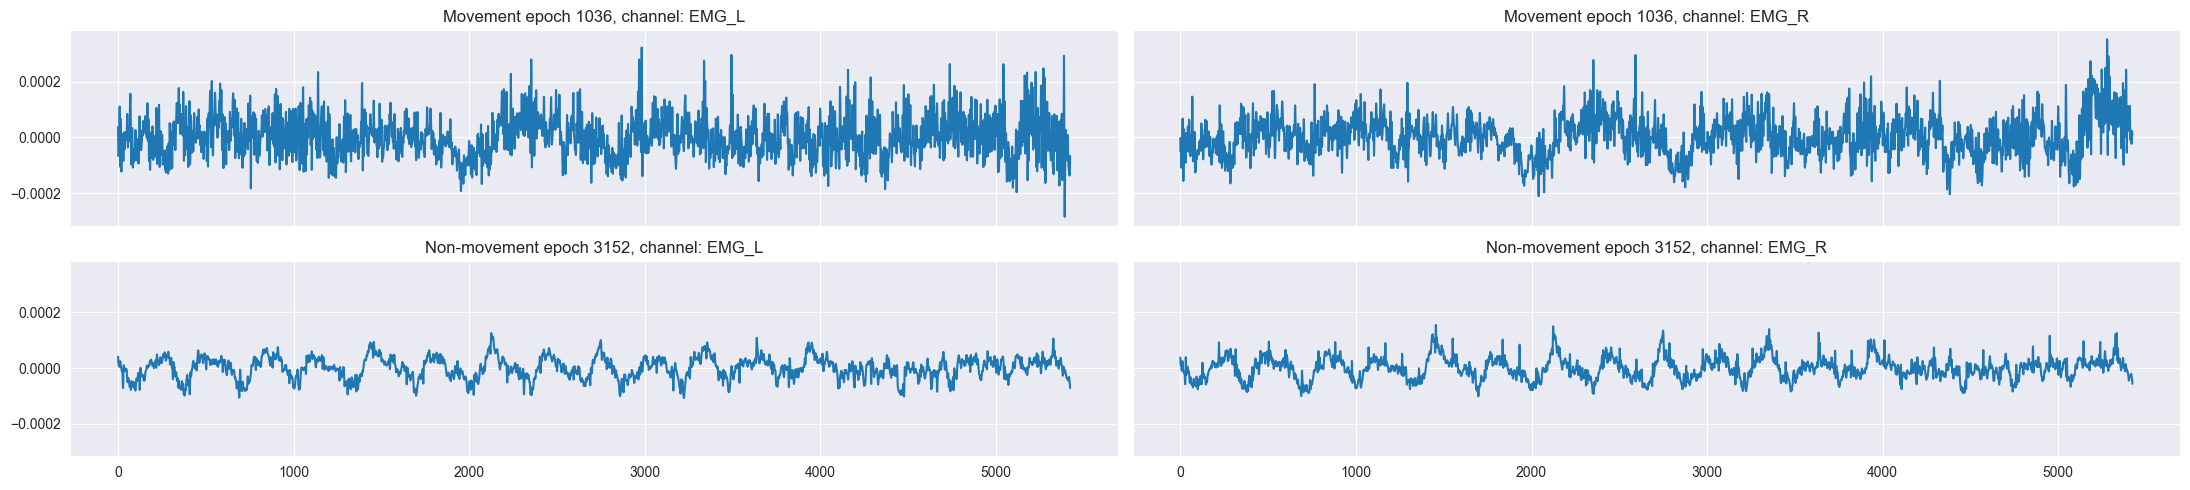

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 5), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].plot(epoch_data_1036[0,0,:])
axs[0].set_title("Movement epoch 1036, channel: EMG_L")
axs[1].plot(epoch_data_1036[0,1,:])
axs[1].set_title("Movement epoch 1036, channel: EMG_R")
axs[2].plot(epoch_data_3152[0,0,:])
axs[2].set_title("Non-movement epoch 3152, channel: EMG_L")
axs[3].plot(epoch_data_3152[0,1,:])
axs[3].set_title("Non-movement epoch 3152, channel: EMG_R")

plt.tight_layout()
plt.show()

### Two different kinds of non-movement epochs

There seem to be two types of non-movement EMG epochs, clearly separable by eye. Let's plot an example of those two in the same manner.

In [42]:
epoch_1098 = epochs[1098]
epoch_data_1098 = epoch_1098.get_data()
epoch_1098.metadata

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_823/3212742817.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data_1098 = epoch_1098.get_data()


,animal_id,genotype,epochs_start_end_samples,epochs_start_end_frames,movement
1098,39508,DRD2-WT,7662699-7668122,211892.63802941085-212042.49009378106,False


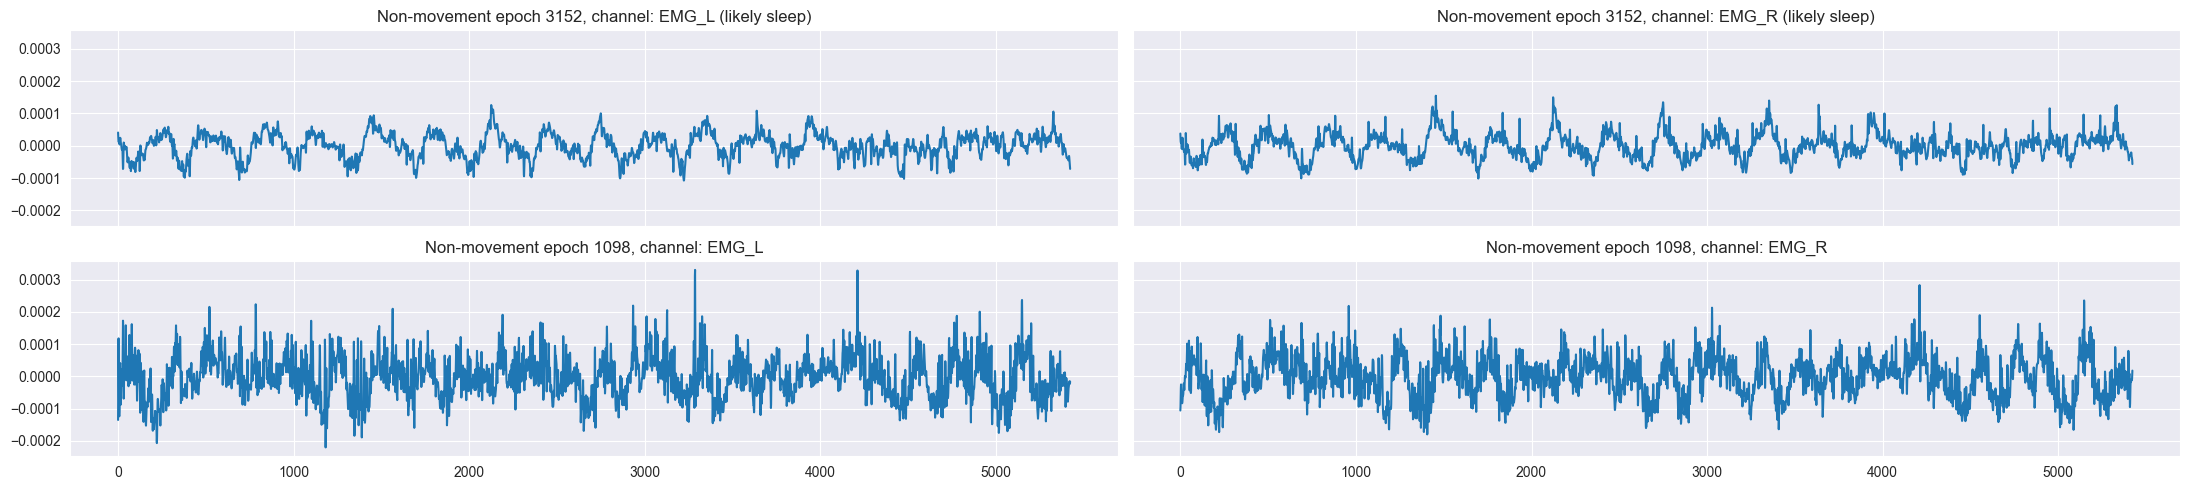

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 5), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].plot(epoch_data_3152[0,0,:])
axs[0].set_title("Non-movement epoch 3152, channel: EMG_L (likely sleep)")
axs[1].plot(epoch_data_3152[0,1,:])
axs[1].set_title("Non-movement epoch 3152, channel: EMG_R (likely sleep)")
axs[2].plot(epoch_data_1098[0,0,:])
axs[2].set_title("Non-movement epoch 1098, channel: EMG_L")
axs[3].plot(epoch_data_1098[0,1,:])
axs[3].set_title("Non-movement epoch 1098, channel: EMG_R")
plt.tight_layout()
plt.show()

It is evident that there's a big difference between the slow-wave, non-gamma wave epoch and the movement one. But the non-movement epoch that does have gamma waves is more similar to the movement one. This makes it hard to distinguish the two. 

Now, we will try different measures to separate the two.

First, let's try something that has to do with the amplitude.

In [44]:
df_test_features = pd.DataFrame()
for i, (epoch_type, signal) in enumerate({"Non-mov (slow wave)": epoch_data_3152, "Non-mov (other)": epoch_data_1098, "Movement": epoch_data_1036}.items()):
    signal_l = signal[0,0,:]
    
    peak_to_peak_amplitude = np.max(signal_l) - np.min(signal_l)
    rms_amplitude = np.sqrt(np.mean(signal_l**2))
    peak_amplitude = np.max(np.abs(signal_l))
    zero_crossings = np.where(np.diff(np.sign(signal_l)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal_l)
    # envelope
    analytic_signal = hilbert(signal_l)
    envelope_amplitude = np.abs(analytic_signal)
    mean_envelope_amplitude = np.mean(envelope_amplitude)
    # envelope auc
    masked_series = np.where(envelope_amplitude > 0, envelope_amplitude, 0)
    envelope_amplitude_auc = np.trapz(masked_series)
    
    df_test_features = pd.concat([df_test_features, pd.DataFrame({
        "Epoch type": epoch_type,
        "Peak-to-Peak Amplitude": peak_to_peak_amplitude,
        "RMS Amplitude": rms_amplitude,
        "Peak Amplitude": peak_amplitude,
        "Zero Crossing Rate": zero_crossing_rate,
        "Envelope Amplitude": mean_envelope_amplitude,
        "Envelope AUC": envelope_amplitude_auc
    }, index=[i])])
df_test_features

,Epoch type,Peak-to-Peak Amplitude,RMS Amplitude,Peak Amplitude,Zero Crossing Rate,Envelope Amplitude,Envelope AUC
0,Non-mov (slow wave),0.000234,0.000038,0.000126,0.048128,0.000048,0.261953
1,Non-mov (other),0.000550,0.000064,0.000330,0.119491,0.000079,0.426281
2,Movement,0.000608,0.000069,0.000323,0.156187,0.000085,0.463170


It seems that most of these features, but especially the zero-crossing-rate and the envelope AUC are very promising. We will now have to see how they perform when clustering all non-movement epochs.

## Feature engineering

Define some functions that help us generate EMG features

In [45]:
def calculate_psd_features(signal, channel_name, sfreq):
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=sfreq, n_jobs=-1, verbose=False)
    
    psds = {}  # slice psd data of epoch based on the defined bands
    for band, (start, end) in freq_bands.items():
        slice_start, slice_end = int(start / 100 * len(freq)), int(end / 100 * len(freq))
        psd_slice = psd[slice_start:slice_end]

        psds[f"{channel_name}_{band}"] = np.mean(np.log(psd_slice))
    return psds


def extract_features(subject_epochs, subject_id):
    subject_epochs = subject_epochs[:-1]
    sfreq = subject_epochs.info['sfreq']
    all_features = []
    channel_names = quality_emgs[int(subject_id)]
    
    # loop through the epochs in the subject's epochs
    for i, epoch in enumerate(subject_epochs):
        
        # features per epoch are stored in here
        features = {}
        
        # loop through each quality EMG channel for this subject and store that channels features
        # in this looped epoch dictionary
        for j, channel_name in enumerate(channel_names):
            
            channel_data = epoch[j, :]  # get the right channel data
            
            # zero-crossings
            zero_crossings = np.where(np.diff(np.sign(channel_data)))[0]
            # envelope
            analytic_signal = hilbert(channel_data)
            envelope_amplitude = np.abs(analytic_signal)
            mean_envelope_amplitude = np.mean(envelope_amplitude)
            # envelope auc
            masked_series = np.where(envelope_amplitude > 0, envelope_amplitude, 0)
            envelope_amplitude_auc = np.trapz(masked_series)
            
            features.update({
                'subject_id': subject_id,
                'epoch_n': i,
                'movement': epochs.metadata["movement"].iloc[i],
                'frame_start_end': epochs.metadata["epochs_start_end_frames"].iloc[i],
                # f"{channel_name} Peak-to-Peak Amplitude": np.max(channel_data) - np.min(channel_data),
                f"{channel_name} RMS Amplitude": np.sqrt(np.mean(channel_data**2)),
                # f"{channel_name} Peak Amplitude": np.max(np.abs(channel_data)),
                f"{channel_name} Zero Crossing Rate": len(zero_crossings) / len(channel_data),
                f"{channel_name} Envelope Amplitude": mean_envelope_amplitude,
                f"{channel_name} Envelope AUC": envelope_amplitude_auc
            })
            features.update(calculate_psd_features(channel_data, channel_name, sfreq))
        # store this epoch's features in the list
        all_features.append(features)
        
    # return list holding dict with all features per epoch
    return all_features

Generate the dictionary holding the features per channel for all epochs

In [46]:
all_features = extract_features(epochs, epochs.metadata["animal_id"].iloc[0])
df_full = pd.DataFrame(all_features)
df_full.head(75)

,subject_id,epoch_n,movement,frame_start_end,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,...,EMG_R_PSD_band1,EMG_R_PSD_band2,EMG_R_PSD_band3,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10
0,39508,0,True,151.6710743042171-301.52313867442706,0.000098,0.125576,0.000116,0.631252,-15.246752,-17.231179,...,-15.481648,-17.419252,-18.021153,-18.279832,-17.917529,-18.526072,-18.777527,-18.643735,-18.437240,-18.395567
1,39508,1,True,751.0793317850569-900.9313961552668,0.000066,0.135903,0.000071,0.385548,-16.081619,-17.212678,...,-15.626170,-17.805603,-18.062218,-18.400314,-18.438500,-18.889111,-18.556444,-18.462664,-18.792026,-18.803344
2,39508,2,True,900.9313961552668-1050.7834605254768,0.000090,0.122257,0.000096,0.520455,-15.198174,-17.482698,...,-14.686194,-17.481915,-17.848681,-17.393813,-17.424666,-18.632950,-18.553471,-18.644793,-18.986796,-17.705694
3,39508,3,True,1200.6355248956868-1350.4875892658965,0.000107,0.126314,0.000103,0.559976,-15.022375,-16.541218,...,-15.190832,-17.244691,-17.927577,-17.495070,-16.844103,-18.093928,-18.383848,-17.688360,-17.394733,-18.126962
4,39508,4,True,1500.3396536361067-1650.1917180063165,0.000064,0.137193,0.000078,0.423843,-15.899348,-17.024079,...,-15.827177,-17.448846,-17.615475,-18.358764,-18.000815,-18.702645,-18.451681,-18.388860,-18.256553,-18.538472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,39508,70,True,13938.06099636353-14087.913060733741,0.000063,0.082058,0.000078,0.423396,-15.606861,-17.704956,...,-15.490205,-17.785668,-18.431480,-18.188856,-18.506255,-18.687969,-18.696722,-19.080596,-19.651493,-19.121378
71,39508,71,False,14087.913060733741-14237.765125103952,0.000073,0.123917,0.000091,0.492476,-15.702065,-16.775679,...,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485
72,39508,72,False,14237.765125103952-14387.61718947416,0.000074,0.132768,0.000089,0.483936,-15.577215,-17.632495,...,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427
73,39508,73,False,14387.61718947416-14537.46925384437,0.000062,0.069519,0.000080,0.432900,-15.698176,-17.695954,...,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775


Seems like this df is correct. Let's transform the movement column, and then also create a df holding only the data we want to cluster on and perform PCA on.

In [48]:
df_full["movement"] = df_full["movement"].astype(int)
df_full.head(75)

,subject_id,epoch_n,movement,frame_start_end,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,...,EMG_R_PSD_band1,EMG_R_PSD_band2,EMG_R_PSD_band3,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10
0,39508,0,1,151.6710743042171-301.52313867442706,0.000098,0.125576,0.000116,0.631252,-15.246752,-17.231179,...,-15.481648,-17.419252,-18.021153,-18.279832,-17.917529,-18.526072,-18.777527,-18.643735,-18.437240,-18.395567
1,39508,1,1,751.0793317850569-900.9313961552668,0.000066,0.135903,0.000071,0.385548,-16.081619,-17.212678,...,-15.626170,-17.805603,-18.062218,-18.400314,-18.438500,-18.889111,-18.556444,-18.462664,-18.792026,-18.803344
2,39508,2,1,900.9313961552668-1050.7834605254768,0.000090,0.122257,0.000096,0.520455,-15.198174,-17.482698,...,-14.686194,-17.481915,-17.848681,-17.393813,-17.424666,-18.632950,-18.553471,-18.644793,-18.986796,-17.705694
3,39508,3,1,1200.6355248956868-1350.4875892658965,0.000107,0.126314,0.000103,0.559976,-15.022375,-16.541218,...,-15.190832,-17.244691,-17.927577,-17.495070,-16.844103,-18.093928,-18.383848,-17.688360,-17.394733,-18.126962
4,39508,4,1,1500.3396536361067-1650.1917180063165,0.000064,0.137193,0.000078,0.423843,-15.899348,-17.024079,...,-15.827177,-17.448846,-17.615475,-18.358764,-18.000815,-18.702645,-18.451681,-18.388860,-18.256553,-18.538472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,39508,70,1,13938.06099636353-14087.913060733741,0.000063,0.082058,0.000078,0.423396,-15.606861,-17.704956,...,-15.490205,-17.785668,-18.431480,-18.188856,-18.506255,-18.687969,-18.696722,-19.080596,-19.651493,-19.121378
71,39508,71,0,14087.913060733741-14237.765125103952,0.000073,0.123917,0.000091,0.492476,-15.702065,-16.775679,...,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485
72,39508,72,0,14237.765125103952-14387.61718947416,0.000074,0.132768,0.000089,0.483936,-15.577215,-17.632495,...,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427
73,39508,73,0,14387.61718947416-14537.46925384437,0.000062,0.069519,0.000080,0.432900,-15.698176,-17.695954,...,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775


Let's investigate whether there are infinite values / NaNs

In [49]:
df_full = df_full.replace([np.inf, -np.inf], np.nan)
df_full.isna().value_counts()

subject_id  epoch_n  movement  frame_start_end  EMG_L RMS Amplitude  EMG_L Zero Crossing Rate  EMG_L Envelope Amplitude  EMG_L Envelope AUC  EMG_L_PSD_band1  EMG_L_PSD_band2  EMG_L_PSD_band3  EMG_L_PSD_band4  EMG_L_PSD_band5  EMG_L_PSD_band6  EMG_L_PSD_band7  EMG_L_PSD_band8  EMG_L_PSD_band9  EMG_L_PSD_band10  EMG_R RMS Amplitude  EMG_R Zero Crossing Rate  EMG_R Envelope Amplitude  EMG_R Envelope AUC  EMG_R_PSD_band1  EMG_R_PSD_band2  EMG_R_PSD_band3  EMG_R_PSD_band4  EMG_R_PSD_band5  EMG_R_PSD_band6  EMG_R_PSD_band7  EMG_R_PSD_band8  EMG_R_PSD_band9  EMG_R_PSD_band10
False       False    False     False            False                False                     False                     False               False            False            False            False            False            False            False            False            False            False             False                False                     False                     False               False            Fal

No Inf/NaNs found.

In [50]:
# remove possible Inf values and grab numerical columns
df_numeric = df_full.iloc[:, 4:]
df_numeric.head()

,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,EMG_L_PSD_band3,EMG_L_PSD_band4,EMG_L_PSD_band5,EMG_L_PSD_band6,...,EMG_R_PSD_band1,EMG_R_PSD_band2,EMG_R_PSD_band3,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10
0,0.000098,0.125576,0.000116,0.631252,-15.246752,-17.231179,-17.944220,-18.308751,-17.775963,-18.337081,...,-15.481648,-17.419252,-18.021153,-18.279832,-17.917529,-18.526072,-18.777527,-18.643735,-18.437240,-18.395567
1,0.000066,0.135903,0.000071,0.385548,-16.081619,-17.212678,-17.731739,-17.827882,-17.984471,-18.111459,...,-15.626170,-17.805603,-18.062218,-18.400314,-18.438500,-18.889111,-18.556444,-18.462664,-18.792026,-18.803344
2,0.000090,0.122257,0.000096,0.520455,-15.198174,-17.482698,-18.097350,-17.796972,-16.716248,-17.718619,...,-14.686194,-17.481915,-17.848681,-17.393813,-17.424666,-18.632950,-18.553471,-18.644793,-18.986796,-17.705694
3,0.000107,0.126314,0.000103,0.559976,-15.022375,-16.541218,-16.944834,-17.369982,-17.174621,-17.653709,...,-15.190832,-17.244691,-17.927577,-17.495070,-16.844103,-18.093928,-18.383848,-17.688360,-17.394733,-18.126962
4,0.000064,0.137193,0.000078,0.423843,-15.899348,-17.024079,-17.494550,-18.194648,-18.188823,-18.627644,...,-15.827177,-17.448846,-17.615475,-18.358764,-18.000815,-18.702645,-18.451681,-18.388860,-18.256553,-18.538472


In [51]:
df_numeric.describe()

,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,EMG_L_PSD_band3,EMG_L_PSD_band4,EMG_L_PSD_band5,EMG_L_PSD_band6,...,EMG_R_PSD_band1,EMG_R_PSD_band2,EMG_R_PSD_band3,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10
count,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,...,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000
mean,0.000081,0.122425,0.000094,0.511595,-15.405025,-17.133458,-17.846000,-18.098777,-18.111700,-18.408654,...,-15.367519,-17.313017,-17.968175,-18.166464,-18.164526,-18.475789,-18.472840,-18.526010,-18.509764,-18.441909
std,0.000063,0.035492,0.000052,0.281508,0.644492,0.532269,0.556915,0.557014,0.684038,0.705750,...,0.629202,0.542959,0.549928,0.537822,0.626038,0.598951,0.626656,0.607090,0.569750,0.588923
min,0.000025,0.011433,0.000031,0.165930,-19.598227,-23.020485,-23.582231,-24.070894,-24.264541,-24.117683,...,-17.770998,-20.860768,-21.887449,-22.505685,-22.856660,-23.180258,-23.682150,-23.804882,-24.099159,-24.198202
25%,0.000066,0.107874,0.000081,0.436738,-15.714873,-17.400296,-18.115358,-18.292087,-18.259051,-18.542512,...,-15.656405,-17.598216,-18.262245,-18.413574,-18.345219,-18.657323,-18.625826,-18.689702,-18.721755,-18.659419
50%,0.000071,0.131293,0.000086,0.466919,-15.513410,-17.186675,-17.883170,-18.078029,-18.019357,-18.313680,...,-15.470566,-17.392296,-18.058070,-18.193713,-18.114347,-18.444317,-18.401270,-18.455868,-18.449534,-18.373537
75%,0.000078,0.147151,0.000094,0.507148,-15.271681,-16.968335,-17.640227,-17.853759,-17.817345,-18.093343,...,-15.238368,-17.168229,-17.811377,-17.947473,-17.887693,-18.210723,-18.177744,-18.213939,-18.204650,-18.099869
max,0.000959,0.189010,0.000923,5.002618,-9.835054,-11.829249,-13.447936,-14.342623,-14.483764,-15.283719,...,-9.785833,-11.721904,-13.340509,-14.292483,-14.356958,-15.167122,-15.555718,-15.490457,-15.785181,-16.078350


## Principle Component Analysis & Clustering

In [52]:
# scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

Now, lets PCA

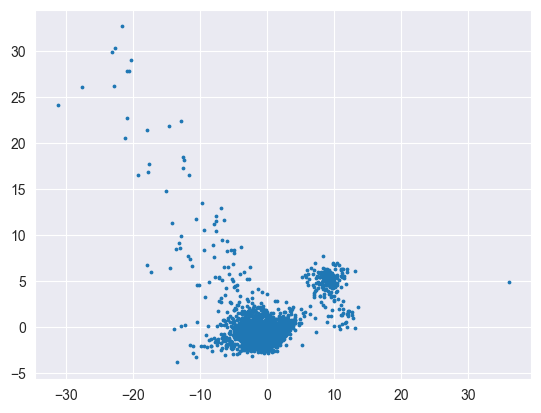

In [53]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
plt.scatter(comp[:, 0], comp[:, 1], s=3)

### Non-movement epochs

What we are mainly interested in is splitting the sleep, from non-sleep non-movement epochs. So that is what we try to do here.

In [56]:
df_non_mov = df_full[df_full.movement == 0]
df_numeric = df_non_mov.iloc[:, 4:]
df_numeric.head()

,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,EMG_L_PSD_band3,EMG_L_PSD_band4,EMG_L_PSD_band5,EMG_L_PSD_band6,...,EMG_R_PSD_band1,EMG_R_PSD_band2,EMG_R_PSD_band3,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10
71,0.000073,0.123917,0.000091,0.492476,-15.702065,-16.775679,-17.573388,-18.007780,-17.868700,-18.168565,...,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485
72,0.000074,0.132768,0.000089,0.483936,-15.577215,-17.632495,-17.863063,-18.091799,-18.139303,-18.242354,...,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427
73,0.000062,0.069519,0.000080,0.432900,-15.698176,-17.695954,-18.646356,-18.569602,-19.236664,-19.131444,...,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775
94,0.000066,0.110824,0.000082,0.442893,-15.487121,-17.173336,-17.466229,-18.119674,-17.899242,-18.363223,...,-15.666305,-17.603781,-17.672099,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657
231,0.000069,0.135349,0.000086,0.468422,-15.401940,-17.160920,-18.242558,-18.503505,-18.102591,-18.497461,...,-15.376889,-17.518799,-18.421073,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330


#### PCA on non-movement epochs

We have generated a huge features dataframe a bit earlier in this notebook. Let's first try PCA on all numerical features.

In [57]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

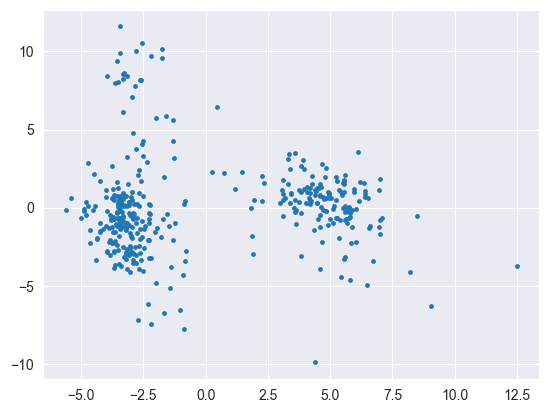

In [58]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
plt.scatter(comp[:, 0], comp[:, 1], s=6)

Now we report the explained variance by the two components

In [59]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained variance ratio of component {i+1}: {ratio:.2%}")

print("\nCumulative explained variance ratio:")
for i, cumulative_ratio in enumerate(cumulative_explained_variance_ratio):
    print(f"First {i+1} components: {cumulative_ratio:.2%}")

Explained variance ratio of component 1: 58.06%
Explained variance ratio of component 2: 31.26%

Cumulative explained variance ratio:
First 1 components: 58.06%
First 2 components: 89.32%


Now, let's get insight into the feature contributions to the PCA

In [66]:
feature_contributions = np.abs(pca.components_)

feat_contr_df = pd.DataFrame()
feat_contr_df["features"] = df_numeric.columns

for i, component in enumerate(feature_contributions):
    feature_contribs = []
    for j, feature_contribution in enumerate(component):
        feature_contribs.append(feature_contribution)
    feat_contr_df[f"Component {i+1}"] = feature_contribs
    
feat_contr_df

,features,Component 1,Component 2
0,EMG_L RMS Amplitude,0.026751,0.314827
1,EMG_L Zero Crossing Rate,0.235708,0.054635
2,EMG_L Envelope Amplitude,0.000267,0.328947
3,EMG_L Envelope AUC,0.000277,0.328949
4,EMG_L_PSD_band1,0.089634,0.297262
5,EMG_L_PSD_band2,0.031082,0.254881
6,EMG_L_PSD_band3,0.205112,0.131679
7,EMG_L_PSD_band4,0.233103,0.050061
8,EMG_L_PSD_band5,0.241518,0.006844
9,EMG_L_PSD_band6,0.242346,0.008158


#### Non-movement epochs clustering

We have generated a huge features dataframe a bit earlier in this notebook. Let's first try to cluster on all numerical features

In [85]:
kmeans = KMeans(random_state=40, n_clusters=2)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([150, 239])

In [86]:
df_plot = pd.concat([df_non_mov.reset_index(drop=True), pd.DataFrame(comp)], axis=1)  # add PCA components 1 and 2 to df
df_plot["cluster"] = kmeans.labels_  # add cluster labels
df_plot.head()

,subject_id,epoch_n,movement,frame_start_end,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,...,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10,0,1,cluster
0,39508,71,0,14087.913060733741-14237.765125103952,0.000073,0.123917,0.000091,0.492476,-15.702065,-16.775679,...,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485,5.784020,-0.609100,0
1,39508,72,0,14237.765125103952-14387.61718947416,0.000074,0.132768,0.000089,0.483936,-15.577215,-17.632495,...,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427,5.227425,0.483613,0
2,39508,73,0,14387.61718947416-14537.46925384437,0.000062,0.069519,0.000080,0.432900,-15.698176,-17.695954,...,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775,1.476447,2.278843,0
3,39508,94,0,17684.362605618782-17834.21466998899,0.000066,0.110824,0.000082,0.442893,-15.487121,-17.173336,...,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657,5.484630,0.783132,0
4,39508,231,0,44058.325934775734-44208.17799914594,0.000069,0.135349,0.000086,0.468422,-15.401940,-17.160920,...,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330,4.200178,0.513875,0


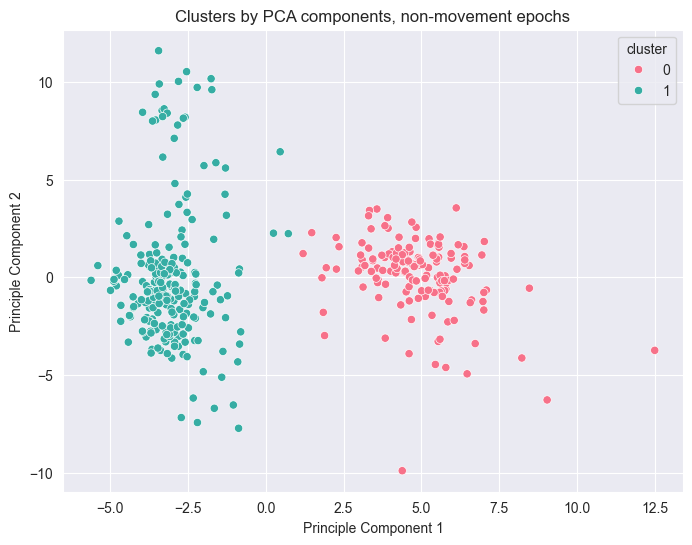

In [87]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster", palette=sns.color_palette("husl", 2))
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Now, let's plot the average signals of the two clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


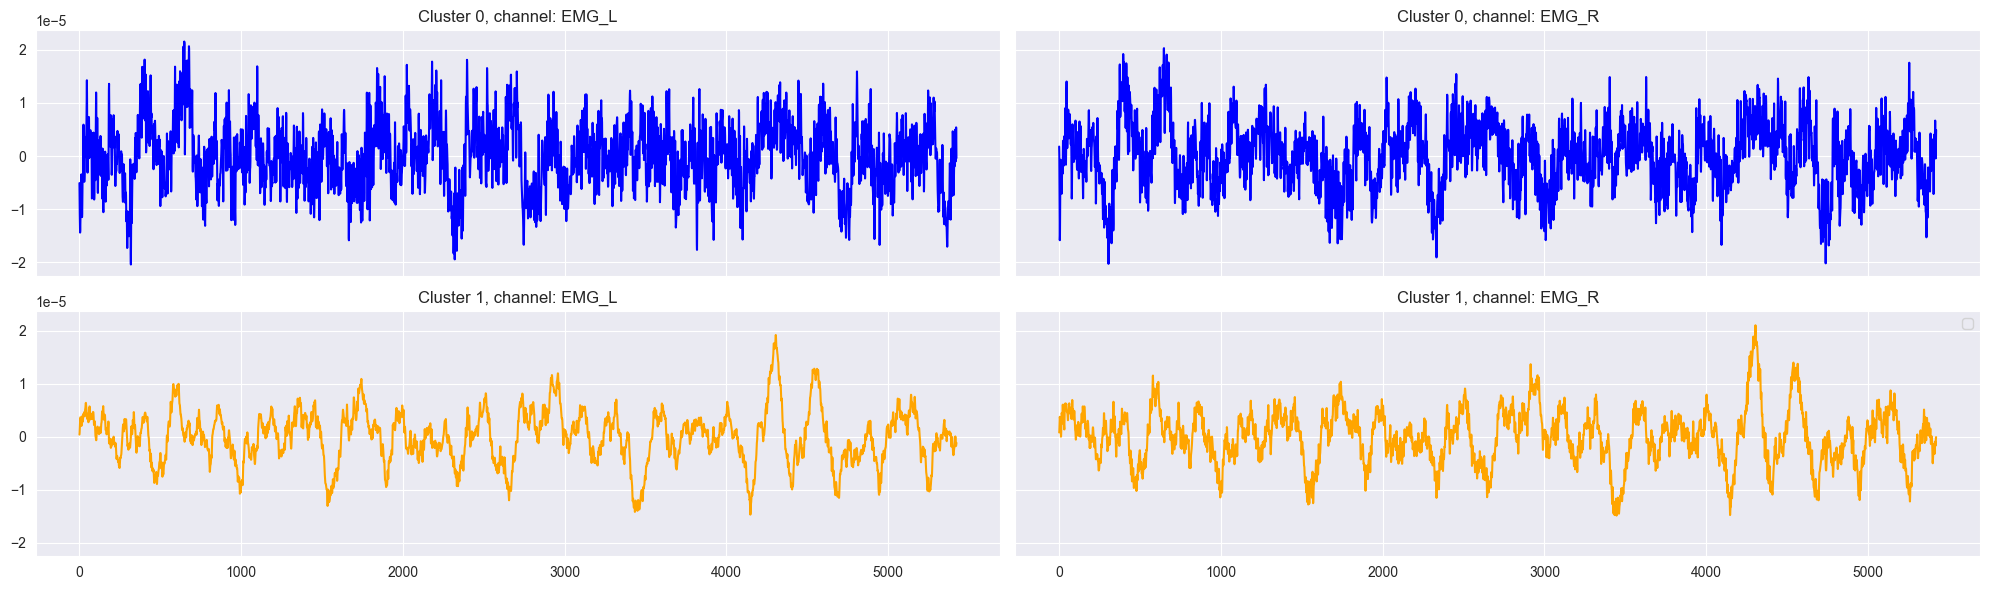

In [88]:
unique_clusters = df_plot["cluster"].unique()
unique_emg_chans = ["EMG_L", "EMG_R"]

fig, axes = plt.subplots(nrows=len(unique_emg_chans), ncols=len(unique_clusters), figsize=(20, 3 * len(unique_emg_chans)), sharex=True, sharey=True)
axes = axes.ravel()

i = 0
for cluster in unique_clusters:
    # get the cluster data from the dataframe
    cluster_data = df_plot[df_plot["cluster"] == cluster]
    
    for emg_chan in unique_emg_chans:

        # get epoch indexes
        epoch_indexes = cluster_data["epoch_n"].unique()
        # get correct epoch data
        epoch_data = epochs[epoch_indexes].get_data(picks=emg_chan)
        # average the epochs of this channel and cluster
        mean = np.mean(epoch_data, axis=0)[0]
        
        axes[i].plot(mean, color="orange" if cluster == 1 else "blue")
        axes[i].set_title(f"Cluster {cluster}, channel: {emg_chan}")
        i += 1

plt.legend()
plt.tight_layout()
plt.show()

The average signals clearly indicate which of our clusters is the 'sleep' one, namely cluster 1.

Now, what if we try 3 clusters instead of 2? It could be that there are multiple types of sleep/rest in here.

In [89]:
kmeans = KMeans(random_state=40, n_clusters=3)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([206,  32, 151])

In [90]:
df_plot = pd.concat([df_non_mov.reset_index(drop=True), pd.DataFrame(comp)], axis=1)  # add PCA components 1 and 2 to df
df_plot["cluster"] = kmeans.labels_  # add cluster labels
df_plot.head()

,subject_id,epoch_n,movement,frame_start_end,EMG_L RMS Amplitude,EMG_L Zero Crossing Rate,EMG_L Envelope Amplitude,EMG_L Envelope AUC,EMG_L_PSD_band1,EMG_L_PSD_band2,...,EMG_R_PSD_band4,EMG_R_PSD_band5,EMG_R_PSD_band6,EMG_R_PSD_band7,EMG_R_PSD_band8,EMG_R_PSD_band9,EMG_R_PSD_band10,0,1,cluster
0,39508,71,0,14087.913060733741-14237.765125103952,0.000073,0.123917,0.000091,0.492476,-15.702065,-16.775679,...,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485,5.784020,-0.609100,2
1,39508,72,0,14237.765125103952-14387.61718947416,0.000074,0.132768,0.000089,0.483936,-15.577215,-17.632495,...,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427,5.227425,0.483613,2
2,39508,73,0,14387.61718947416-14537.46925384437,0.000062,0.069519,0.000080,0.432900,-15.698176,-17.695954,...,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775,1.476447,2.278843,2
3,39508,94,0,17684.362605618782-17834.21466998899,0.000066,0.110824,0.000082,0.442893,-15.487121,-17.173336,...,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657,5.484630,0.783132,2
4,39508,231,0,44058.325934775734-44208.17799914594,0.000069,0.135349,0.000086,0.468422,-15.401940,-17.160920,...,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330,4.200178,0.513875,2


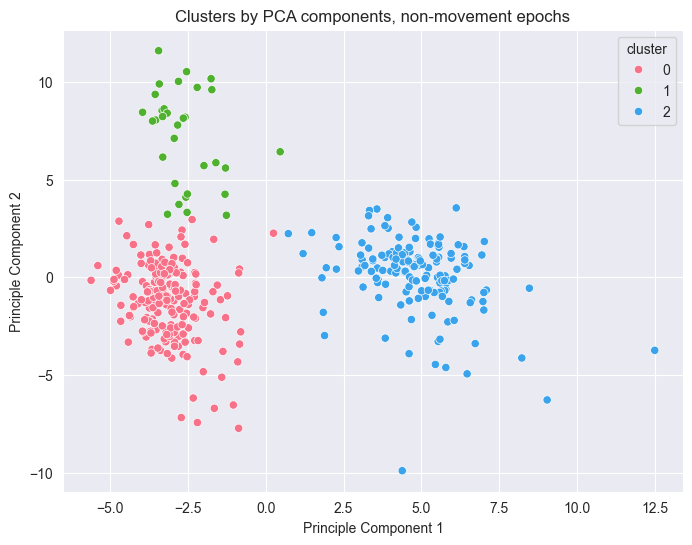

In [91]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster", palette=sns.color_palette("husl", 3))
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Taken from this figure, cluster 1 might be outliers.

Now, let's plot the average signals of the three clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


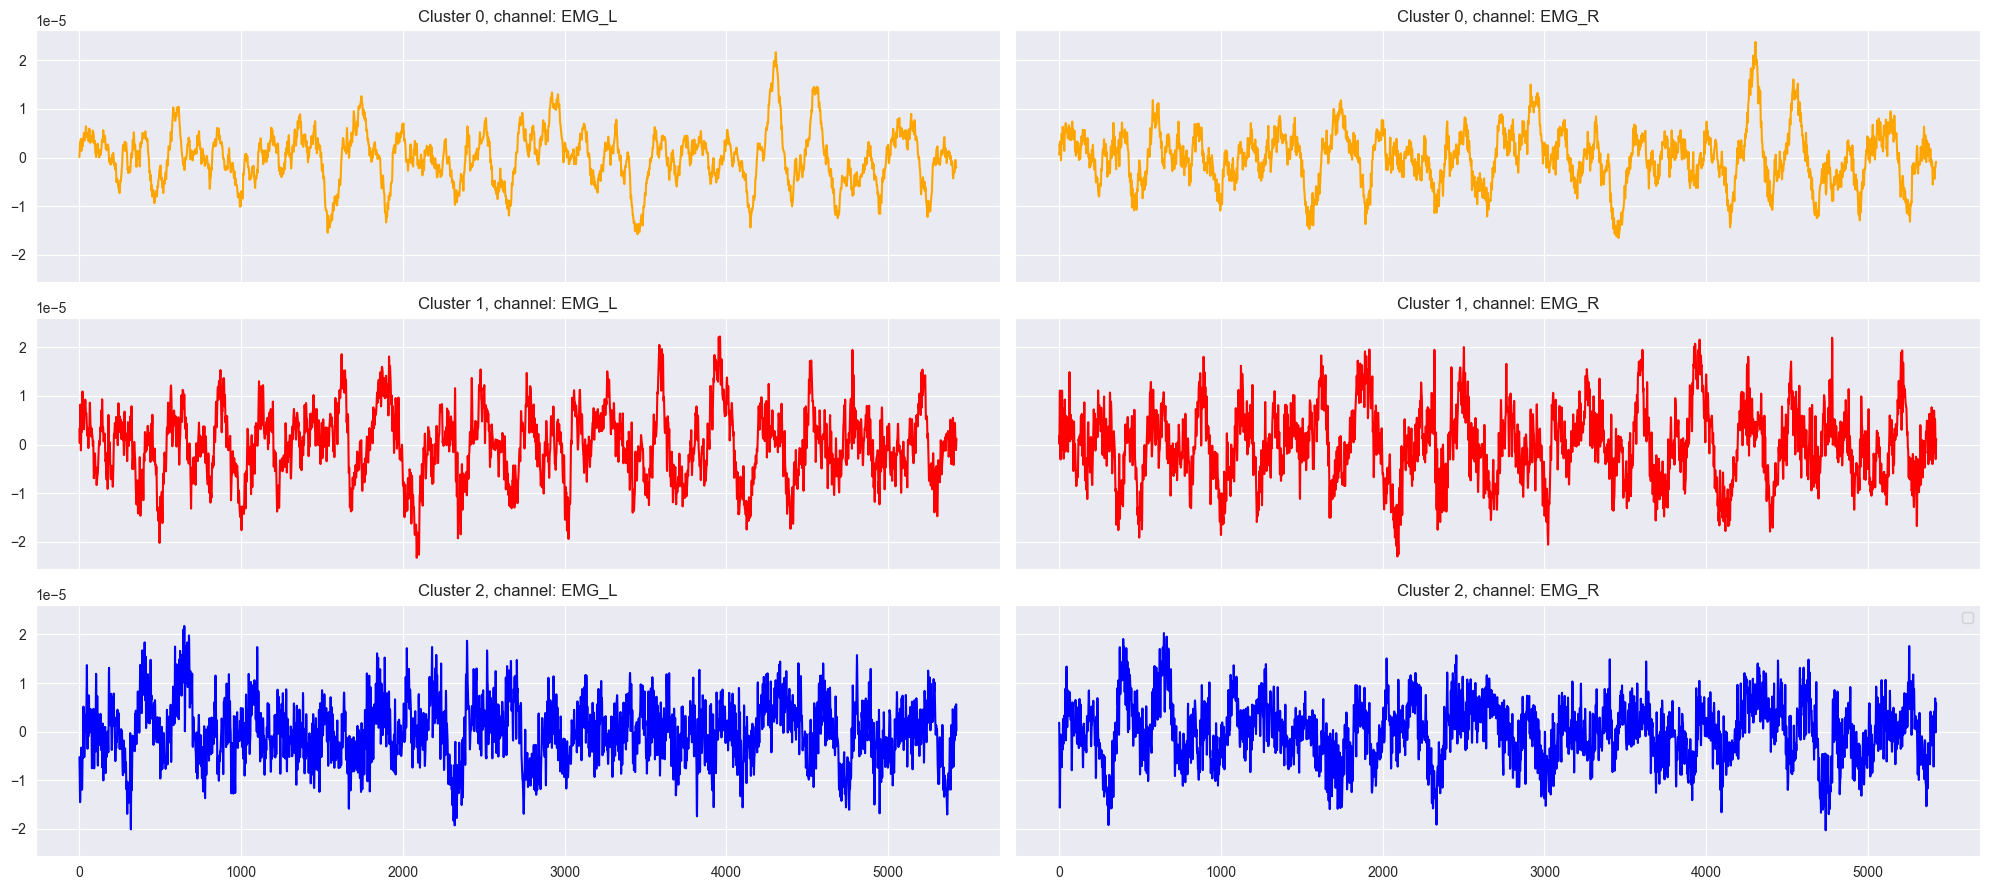

In [102]:
unique_clusters = df_plot["cluster"].unique()
unique_emg_chans = ["EMG_L", "EMG_R"]

fig, axes = plt.subplots(ncols=len(unique_emg_chans), nrows=len(unique_clusters), figsize=(20, 3 * len(unique_clusters)), sharex=True, sharey=True)
axes = axes.ravel()

i = 0
for cluster in np.sort(unique_clusters):
    # get the cluster data from the dataframe
    cluster_data = df_plot[df_plot["cluster"] == cluster]
    
    for emg_chan in unique_emg_chans:

        # get epoch indexes
        epoch_indexes = cluster_data["epoch_n"].unique()
        # get correct epoch data
        epoch_data = epochs[epoch_indexes].get_data(picks=emg_chan)
        # average the epochs of this channel and cluster
        mean = np.mean(epoch_data, axis=0)[0]
        
        colors = {0: "orange", 1: "red", 2: "blue"}
            
        axes[i].plot(mean, color=colors[cluster])
        axes[i].set_title(f"Cluster {cluster}, channel: {emg_chan}")
        i += 1

plt.legend()
plt.tight_layout()
plt.show()

Concluding: From here, we can easily yoink the sleep and outlier clusters, and proceed to manually scoring the remaining non-movement epochs (grooming, eating, resting, etc.)

Let's quickly save the epochs in the non-sleep, non-movement cluster to a file.

In [104]:
epoch_indexes_to_export = df_plot[df_plot["cluster"] == 2]["epoch_n"]
epoch_indexes_to_export

0        71
1        72
2        73
3        94
4       231
       ... 
291    3089
310    3112
359    3165
360    3166
361    3167
Name: epoch_n, Length: 151, dtype: int64

In [109]:
epochs[epoch_indexes_to_export].save(os.path.join(epochs_dir, "non_mov_epochs_to_classify_39508-epo.fif"))

Lets do the same for the sleep epochs.

In [110]:
epoch_indexes_to_export_sleep = df_plot[df_plot["cluster"] == 0]["epoch_n"]
epoch_indexes_to_export_sleep

138    2837
139    2838
140    2839
141    2840
142    2841
       ... 
384    3190
385    3191
386    3192
387    3193
388    3194
Name: epoch_n, Length: 206, dtype: int64

In [111]:
epochs[epoch_indexes_to_export_sleep].save(os.path.join(epochs_dir, "sleep_epochs_39508-epo.fif"))

Done for subject 39508. This notebook's procedure needs to later be applied to all subjects using an efficient script.